# Traffic sign detection 
## Setup dependencies

In [1]:
import tensorflow as tf
from skimage import transform
from skimage import data
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.color import rgb2gray
import random

## Playfield

In [2]:
# Initialize two constants
x1 = tf.constant([1,2,3,4])
x2 = tf.constant([5,6,7,8])

# Multiply
result = tf.multiply(x1, x2)

# Print the result
print(result)

Tensor("Mul:0", shape=(4,), dtype=int32)


## Load data

In [3]:
def load_data(data_directory):
    # Get all subdirectories of data_dir. Each directory represents a label. 
    directories = [directory for directory in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, directory))]
    
    labels = []
    images = []
    for directory in directories:
        label_directory = os.path.join(data_directory, directory)
        file_names = [os.path.join(label_directory, file)
                     for file in os.listdir(label_directory)
                     if file.endswith(".ppm")]
        for file in file_names:
            images.append(data.imread(file))
            labels.append(int(directory))
    return images, labels

train_data_directory = "../data/train"
test_data_directory = "../data/test"

images, labels = load_data(train_data_directory)

In [4]:
# transform to array
images_array = np.array(images)
labels_array = np.array(labels)

print(images_array.ndim)
print(images_array.size)

# Print the first instance of `images`
# print(images_array[0])

1
4575


In [5]:
# Print the `labels` dimensions
print(labels_array.ndim)

# Print the number of `labels`'s elements
print(labels_array.size)

# Count the number of labels
n_labels = len(set(labels_array))
n_labels

1
4575


62

## Inspect data

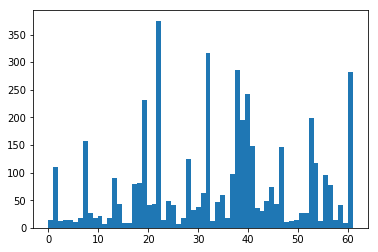

In [6]:
plt.hist(labels, n_labels)
plt.show()

### Conclusion
some signs are overpresent (22, 32,38, 61)

In [7]:
# define random traffic sign for comparison
traffic_signs=[300, 2250, 3650, 4000] # some indexes to inspect traffic signs

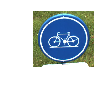

shape: (236, 256, 3), min: 0, max: 255


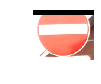

shape: (133, 164, 3), min: 0, max: 255


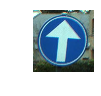

shape: (122, 121, 3), min: 0, max: 255


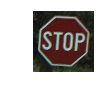

shape: (123, 123, 3), min: 0, max: 215


In [8]:
for idx in range(len(traffic_signs)):
    plt.subplot(1, len(traffic_signs), idx+1)
    plt.axis("off")
    traffic_sign_image = images[traffic_signs[idx]]
    plt.imshow(traffic_sign_image)
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    
    print("shape: {0}, min: {1}, max: {2}".format(traffic_sign_image.shape,
                                                  traffic_sign_image.min(),
                                                  traffic_sign_image.max()))

### Conclusion 
Some signs are larger

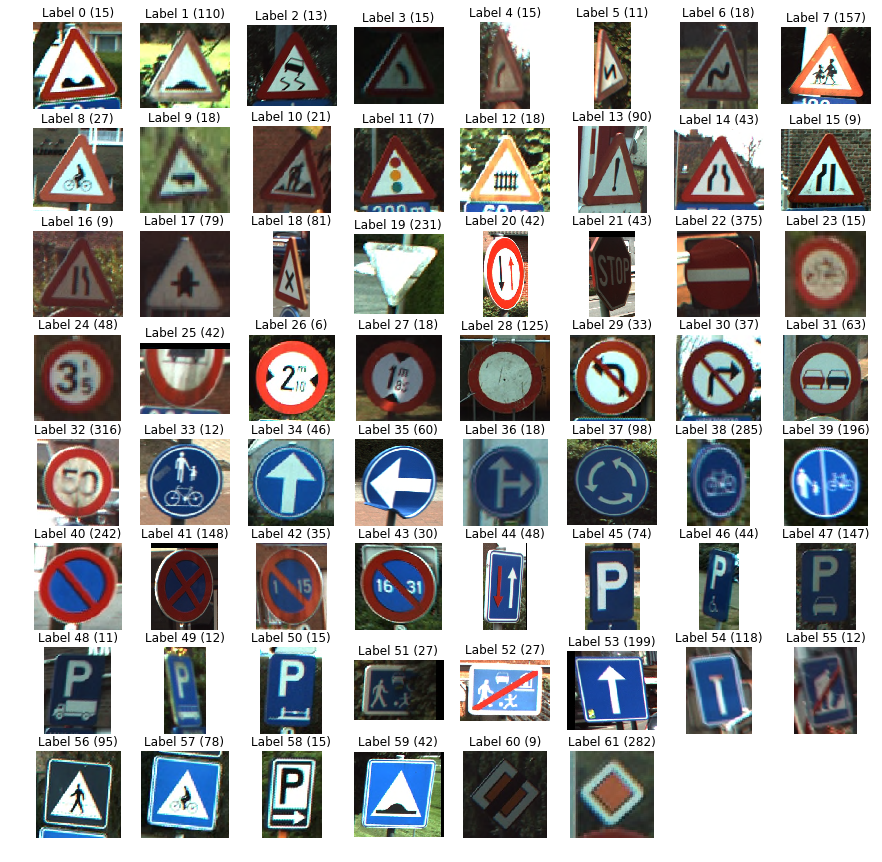

In [9]:
unique_labels = set(labels)

plt.figure(figsize=(15,15))
counter = 1

for label in unique_labels:
    image = images[labels.index(label)]
    plt.subplot(8, 8, counter)
    plt.axis("off")
    plt.title("Label {0} ({1})".format(label, labels.count(label)))
    counter+=1
    plt.imshow(image)
    
plt.show()

## Feature extraction
### Normalization - Rescaling Images 

In [10]:
images32 = [transform.resize(image, (28,28)) for image in images]
images32 = np.array(images32)

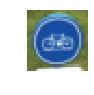

shape: (28, 28, 3), min: 0.08711484593837535, max: 0.9921568627450981


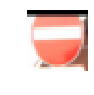

shape: (28, 28, 3), min: 0.0, max: 0.9921568627450981


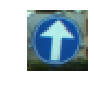

shape: (28, 28, 3), min: 0.052893657462985216, max: 0.9652661064425767


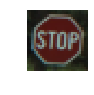

shape: (28, 28, 3), min: 0.052254651860744294, max: 0.7078168767507003


In [11]:
for idx in range(len(traffic_signs)):
    plt.subplot(1, len(traffic_signs), idx+1)
    plt.axis('off')
    traffic_sign_image = images32[traffic_signs[idx]]
    plt.imshow(traffic_sign_image)
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(traffic_sign_image.shape, 
                                                  traffic_sign_image.min(), 
                                                  traffic_sign_image.max()))

### Image conversion to grayscale

In [12]:
images32 = rgb2gray(np.array(images32))

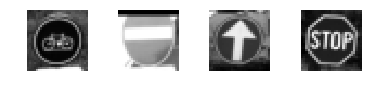

(4575, 28, 28)


In [13]:
for idx in range(len(traffic_signs)):
    plt.subplot(1, len(traffic_signs), idx+1)
    plt.axis('off')
    plt.imshow(images32[traffic_signs[idx]], cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
plt.show()

print(images32.shape)

## Deep Learning with Tensorflow

### Modeling the neural network

In [14]:
# setup placeholder for inputs and labels
x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28]) # input
y = tf.placeholder(dtype = tf.int32, shape = [None]) # label
# placeholder for the real values (images). They get filled at the session.run()

In [15]:
# flattening the input images
images_flat = tf.contrib.layers.flatten(x) 
images_flat # shape of grayscale iamges 784 instead of 28,28


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.


<tf.Tensor 'Flatten/flatten/Reshape:0' shape=(?, 784) dtype=float32>

### ReLU (activation function)
ReLU (activation function), because no one uses sigmoid anymore

![](data/relu.png)

In [16]:
# create fully connected layer with 62 logits
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)
# Logits is a function that maps probibilities

# Logits is the function operates on the unscaled output of previous layers, 
# and that uses the relative scale to understand the units is linear.

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
# define loss function
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits) )
# sparse_softmax_cross_entropy_with_logits =
# measures probability error in discrete classification tasks 
# in which the classes are mutually exclusive.

# reduce mean to get the mean of the elements accross dimensions of a tensor

In [18]:
# define optimization function (ADAM, alternatively SGD, RMSprop, ...)
train_operation = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [19]:
# converts logits to label indexes
correct_prediction = tf.argmax(logits, 1)

In [20]:
# Define accuracy metric
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("images_flat: ",images_flat)
print("logits: ", logits)
print("loss: ",loss)
print("predicted_labels: ", correct_prediction)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 784), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


## Running the neural network

In [21]:
session = tf.Session()
session.run(tf.global_variables_initializer())


for epoch in range(201):
    # print('EPOCH', epoch)
    # feed_dict = data format
    _, accuracy_value = session.run([train_operation, accuracy], 
                                    feed_dict={x: images32, y: labels})
    print("Epoch {0} Loss: {1}".format(epoch, accuracy_value))
    #if epoch % 10 == 0:
    #    print("Epoch {0} Loss: {1}".format(epoch,loss))

Epoch 0 Loss: 20.488525390625
Epoch 1 Loss: 28.775300979614258
Epoch 2 Loss: 28.251585006713867
Epoch 3 Loss: 25.11650276184082
Epoch 4 Loss: 23.068634033203125
Epoch 5 Loss: 22.74142074584961
Epoch 6 Loss: 23.1962833404541
Epoch 7 Loss: 24.24262237548828
Epoch 8 Loss: 26.295955657958984
Epoch 9 Loss: 29.790163040161133
Epoch 10 Loss: 33.920875549316406
Epoch 11 Loss: 37.57573699951172
Epoch 12 Loss: 39.22032928466797
Epoch 13 Loss: 38.68087387084961
Epoch 14 Loss: 37.072349548339844
Epoch 15 Loss: 35.457923889160156
Epoch 16 Loss: 34.251365661621094
Epoch 17 Loss: 33.547542572021484
Epoch 18 Loss: 32.86666488647461
Epoch 19 Loss: 32.361968994140625
Epoch 20 Loss: 31.97333335876465
Epoch 21 Loss: 31.796720504760742
Epoch 22 Loss: 31.7547550201416
Epoch 23 Loss: 31.892677307128906
Epoch 24 Loss: 32.24174880981445
Epoch 25 Loss: 32.71977996826172
Epoch 26 Loss: 33.219234466552734
Epoch 27 Loss: 33.65486526489258
Epoch 28 Loss: 33.98185729980469
Epoch 29 Loss: 34.20437240600586
Epoch 30 L

## Model Evaluation

In [22]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([correct_prediction], feed_dict={x: sample_images})[0]
                        
# Print the real and predicted labels
print(sample_labels)
print(predicted)

[17, 32, 24, 61, 10, 32, 32, 39, 28, 47]
[17 32 24 61  1 32 32 39 32 53]


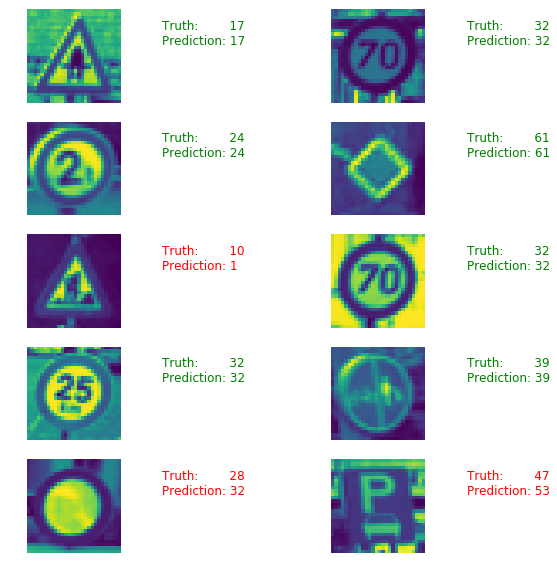

In [23]:
# Display the predictions and the ground truth visually.
figure = plt.figure(figsize=(10, 10))
for idx in range(len(sample_images)):
    truth = sample_labels[idx]
    prediction = predicted[idx]
    plt.subplot(5, 2 ,1+idx)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[idx])

plt.show()

# Complete 

In [24]:
# load test data
test_images, test_labels = load_data(test_data_directory)

In [25]:
# transform images to 28 by 28 pixels
test_images28 = [transform.resize(image, (28,28)) for image in test_images]

In [26]:
# convert to grayscale
test_images28 = rgb2gray(np.array(test_images28))

In [27]:
# run predictions against the full set
predicted = session.run([correct_prediction], feed_dict={x: test_images28})[0]

In [28]:
# Evaluate model
# correct matches
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
# calculate accuracy
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.671


In [29]:
session.close()

# Whats next
- Apply regularized LDA on the data before you feed it to your model. This is a suggestion that comes from one of the original papers, written by the researchers that gathered and analyzed this dataset.
- You could also, as said in the tutorial itself, also look at some other data augmentation operations that you can perform on the traffic sign images. Additionally, you could also try to tweak this network further; The one that you have created now was fairly simple.
- Early stopping: Keep track of the training and testing error while you train the neural network. Stop training when both errors go down and then suddenly go back up - this is a sign that the neural network has started to overfit the training data.
- Play around with the optimizers.